# Sentiment Analysis with an RNN
<img src="http://www.polyvista.com/blog/wp-content/uploads/2015/06/sentiment-customer-exp-large.png">
<p style="font-size:10px;">http://www.polyvista.com/blog/wp-content/uploads/2015/06/sentiment-customer-exp-large.png</p>

## What is Sentiment Analysis?

Sentiment Analysis also know as opinion mining refers to the identification, extraction and study of sentiment states by using natural language processing, text analysis, computational linguistics and biometrics.

## Sentiment Analysis with an Recurrent Neural Network

We will use a RNN for sentiment analysis because we care for the sequence in the data.

### Imports

In [1]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


### Loading in Dataset

In [2]:
data = pd.read_csv('Tweets.csv')
data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)
data.head()

(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,568808746689933312,neutral,1.0000,NaN,NaN,Delta,NaN,meadonmanhattan,NaN,0,@JetBlue trivia contest to win flight. 1 quest...,NaN,2015-02-20 08:25:47 -0800,"iPhone: 28.356075,-81.588827",Eastern Time (US & Canada)
1,567862586374529026,negative,1.0000,Late Flight,0.3612,United,NaN,Tgoody9,NaN,0,@united haha that's fine. Still won't fly @uni...,"[40.69429232, -74.17208436]",2015-02-17 17:46:05 -0800,"Sarasota, Florida",Central Time (US & Canada)
2,569475215832387584,negative,1.0000,Late Flight,1.0000,US Airways,NaN,Sb5551,NaN,0,@USAirways unfortunately patience won't get me...,NaN,2015-02-22 04:34:06 -0800,NaN,NaN
3,569719978993152000,negative,1.0000,Customer Service Issue,1.0000,American,NaN,troubledsoul99,NaN,0,"@AmericanAir Thank you for holding, we apologi...",NaN,2015-02-22 20:46:42 -0800,"Raleigh, NC",NaN
4,568845145510158336,neutral,0.6697,NaN,NaN,US Airways,NaN,MikeSelesky,NaN,0,@USAirways absolutely,NaN,2015-02-20 10:50:25 -0800,NaN,NaN


Removing all columns except the airline_sentiment and text column.

In [3]:
data = data[['airline_sentiment', 'text']]
data.head()

,airline_sentiment,text
0,neutral,@JetBlue trivia contest to win flight. 1 quest...
1,negative,@united haha that's fine. Still won't fly @uni...
2,negative,@USAirways unfortunately patience won't get me...
3,negative,"@AmericanAir Thank you for holding, we apologi..."
4,neutral,@USAirways absolutely


### Data exploration

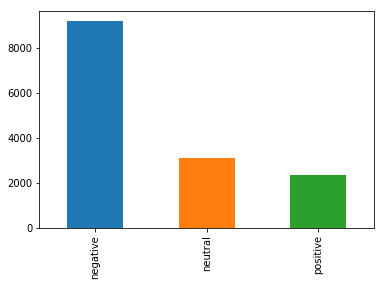

In [4]:
data['airline_sentiment'].value_counts().sort_index().plot.bar()

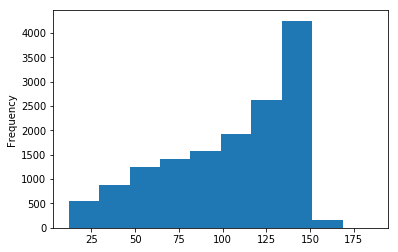

In [5]:
data['text'].str.len().plot.hist()

### Preprocessing

In [6]:
data['text'] = data['text'].str.replace('@VirginAmerica', '')
data.head()

,airline_sentiment,text
0,neutral,@JetBlue trivia contest to win flight. 1 quest...
1,negative,@united haha that's fine. Still won't fly @uni...
2,negative,@USAirways unfortunately patience won't get me...
3,negative,"@AmericanAir Thank you for holding, we apologi..."
4,neutral,@USAirways absolutely


In [7]:
data['text'].apply(lambda x: x.lower()) #transform text to lowercase
data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
data['text'].head()

0    JetBlue trivia contest to win flight 1 questio...
1    united haha thats fine Still wont fly united e...
2    USAirways unfortunately patience wont get me t...
3    AmericanAir Thank you for holding we apologize...
4                                 USAirways absolutely
Name: text, dtype: object

In [8]:
tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(data['text'].values)

X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   17, 1600,    1, 1002,    8,  217,  500,
         377,   10,  284,   61,  218,  356,    6,  324,    1, 1313,  315],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    5,  884,  171,  714,   72,  210,  103,    5,  159,
         102,  552,   94,    6,  104,   22,   98,  197,  157,  305,  553],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   12,
         837, 1257,  210,   30,   19,    1,   11, 3670,   26, 1204,   27,
         138,  722,    3,   23,    9,   62, 1258,   67,   59, 1314,   51],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   13,
          68,    6,    7,  701,   38, 1429,    7,    2,  133,   15,  821,
          21,   83,    1,  354,    1,    4, 1205,   73, 1259,    1,   62],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   

### Creating model

In [9]:
model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 33, 256)           1280000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 33, 256)           525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________


In [11]:
y = pd.get_dummies(data['airline_sentiment']).values
[print(data['airline_sentiment'][i], y[i]) for i in range(0,5)]

neutral [0 1 0]
negative [1 0 0]
negative [1 0 0]
negative [1 0 0]
neutral [0 1 0]


[None, None, None, None, None]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Training model

In [13]:
batch_size = 32
epochs = 8

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/8
 - 93s - loss: 0.6553 - acc: 0.7293
Epoch 2/8
 - 82s - loss: 0.4459 - acc: 0.8311
Epoch 3/8
 - 81s - loss: 0.3577 - acc: 0.8636
Epoch 4/8
 - 81s - loss: 0.3014 - acc: 0.8871
Epoch 5/8
 - 77s - loss: 0.2521 - acc: 0.9055
Epoch 6/8
 - 80s - loss: 0.2129 - acc: 0.9228
Epoch 7/8
 - 82s - loss: 0.1826 - acc: 0.9319
Epoch 8/8
 - 82s - loss: 0.1554 - acc: 0.9439


In [14]:
model.save('sentiment_analysis.h5')

### Testing model

In [15]:
predictions = model.predict(X_test)

[print(data['text'][i], predictions[i], y_test[i]) for i in range(0, 5)]

JetBlue trivia contest to win flight 1 question RT and Follow amp Ill send you answer to enter httptcoAucSYKFUHD via WSJPlus [0.02037652 0.9042143  0.07540911] [0 1 0]
united haha thats fine Still wont fly united ever again Seems like you guys have more problems than anyone else [9.9976367e-01 2.0449981e-04 3.1773252e-05] [1 0 0]
USAirways unfortunately patience wont get me to my boat that leaves at 4 pm I was on hold watching all flights fill up [9.9801528e-01 1.2300106e-03 7.5464684e-04] [1 0 0]
AmericanAir Thank you for holding we apologize for the delay in answering your call To speak to a representative please continue to hold [0.2353948  0.67948174 0.08512338] [0 1 0]
USAirways absolutely [9.9711537e-01 9.4040652e-04 1.9442146e-03] [1 0 0]


[None, None, None, None, None]

In [16]:
pos_count, neu_count, neg_count = 0, 0, 0
real_pos, real_neu, real_neg = 0, 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==2:
        pos_count += 1
    elif np.argmax(prediction)==1:
        neu_count += 1
    else:
        neg_count += 1
    
    if np.argmax(y_test[i])==2:
        real_pos += 1
    elif np.argmax(y_test[i])==1:    
        real_neu += 1
    else:
        real_neg +=1

print('Positive predictions:', pos_count)
print('Neutral predictions:', neu_count)
print('Negative predictions:', neg_count)
print('Real positive:', real_pos)
print('Real neutral:', real_neu)
print('Real negative:', real_neg)

Positive predictions: 463
Neutral predictions: 485
Negative predictions: 1980
Real positive: 479
Real neutral: 606
Real negative: 1843


## Improvements we could implement
<ul>
    <li>Weight classes (because data is skew)</li>
    <li>Train more epochs</li>
    <li>Use bigger network</li>
    <li>Try other word number</li>
</ul>

## Resources

<ul>
    <li><a href="https://programmingwithgilbert.firebaseapp.com/videos/machine-learning-explained/recurrent-neural-networks-lstm-explained">Recurrent Neural Networks Explained (my own post and video)</a></li>
    <li><a href="https://en.wikipedia.org/wiki/Sentiment_analysis">Sentiment Analysis (Wikipedia)</a></li>
    <li><a href="https://www.quora.com/What-is-the-best-way-to-do-sentiment-analysis-with-Python-I%E2%80%99m-looking-for-a-sentiment-analysis-API-that-I-can-add-an-emoticon-dictionary-to-I-have-no-idea-how-to-use-NLTK-Can-anyone-help-me-with-that">What is the best way to do sentiment analysis with Python? (Quora)</a></li>
    <li><a href="https://www.youtube.com/watch?v=si8zZHkufRY">How to Do Sentiment Analysis (Siraj Raval)</a></li>
</ul>